<a href="https://colab.research.google.com/github/NVS-MIT-SHRIKANTSHINDE/Accident-Detection-CNN/blob/main/DreamBooth/ShivamShriraoDreamBooth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# We have many times better workflow than this notebook
# Read (public post) : https://www.patreon.com/posts/full-workflow-sd-98620163
## Tutorial Video for this colab: https://youtu.be/mnCY8uM7E50
### If you want to use custom model and to learn more about folder paths and directories watch tutorial video : https://youtu.be/kIyqAdd_i10
### Our Discord : https://discord.com/servers/software-engineering-courses-secourses-772774097734074388
### Ignore warnings and errors. Leave a comment if not works
### Updated and Verified Working 22 October 2024
### DreamBooth master tutorial : https://youtu.be/Bdl-jWR3Ukc
### Best DreamBooth settings : https://youtu.be/sRdtVanSRl4
### Stable Diffusion playlist : https://www.youtube.com/playlist?list=PL_pbwdIyffsmclLl0O144nQRnezKlNdx3
### Stable Diffusion repo : https://github.com/FurkanGozukara/Stable-Diffusion

## Install Requirements - ignore warnings and errors. if training won't work leave a comment to the tutorial video and hopefully I will fix asap

In [8]:
!wget -q https://gist.githubusercontent.com/FurkanGozukara/be7be5f9f7820d0bb85a3052874f184e/raw/d8d179da6cab0735bd5832029c2dec5163db87b4/train_dreambooth.py
!wget -q https://github.com/ShivamShrirao/diffusers/raw/main/scripts/convert_diffusers_to_original_stable_diffusion.py
%pip uninstall torchtext --yes
%pip install -qq git+https://github.com/ShivamShrirao/diffusers
%pip install torch==2.2.0 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121 --upgrade
%pip install -q -U --pre triton --upgrade
%pip install -q accelerate transformers ftfy gradio natsort safetensors
%pip install bitsandbytes==0.41.3  --upgrade
%pip install xformers==0.0.24  --upgrade
%pip install triton==2.2.0 --upgrade
%pip install diffusers==0.27.0 --upgrade
%pip install huggingface_hub==0.25.2

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Looking in indexes: https://download.pytorch.org/whl/cu121
  Using cached https://download.pytorch.org/whl/cu121/torch-2.2.0%2Bcu121-cp310-cp310-linux_x86_64.whl (757.3 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 86.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 98.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 98.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 110.2 MB/s eta 0:00:00
INFO: pip is still looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a w

## Settings and run

In [2]:
#@markdown If model weights should be saved directly in google drive (takes around 4-5 GB).
save_to_gdrive = False #@param {type:"boolean"}
if save_to_gdrive:
    from google.colab import drive
    drive.mount('/content/drive')

#@markdown Name/Path of the initial model.
MODEL_NAME = "stable-diffusion-v1-5/stable-diffusion-v1-5" #@param {type:"string"}

#@markdown Enter the directory name to save model at.

OUTPUT_DIR = "stable_diffusion_weights/shrikant5" #@param {type:"string"}
if save_to_gdrive:
    OUTPUT_DIR = "/content/drive/MyDrive/" + OUTPUT_DIR
else:
    OUTPUT_DIR = "/content/" + OUTPUT_DIR

print(f"[*] Weights will be saved at {OUTPUT_DIR}")

!mkdir -p $OUTPUT_DIR

[*] Weights will be saved at /content/stable_diffusion_weights/shrikant5


# Start Training

Use the table below to choose the best flags based on your memory and speed requirements. Tested on Tesla T4 GPU.


| `fp16` | `train_batch_size` | `gradient_accumulation_steps` | `gradient_checkpointing` | `use_8bit_adam` | GB VRAM usage | Speed (it/s) |
| ---- | ------------------ | ----------------------------- | ----------------------- | --------------- | ---------- | ------------ |
| fp16 | 1                  | 1                             | TRUE                    | TRUE            | 9.92       | 0.93         |
| no   | 1                  | 1                             | TRUE                    | TRUE            | 10.08      | 0.42         |
| fp16 | 2                  | 1                             | TRUE                    | TRUE            | 10.4       | 0.66         |
| fp16 | 1                  | 1                             | FALSE                   | TRUE            | 11.17      | 1.14         |
| no   | 1                  | 1                             | FALSE                   | TRUE            | 11.17      | 0.49         |
| fp16 | 1                  | 2                             | TRUE                    | TRUE            | 11.56      | 1            |
| fp16 | 2                  | 1                             | FALSE                   | TRUE            | 13.67      | 0.82         |
| fp16 | 1                  | 2                             | FALSE                   | TRUE            | 13.7       | 0.83          |
| fp16 | 1                  | 1                             | TRUE                    | FALSE           | 15.79      | 0.77         |


Add `--gradient_checkpointing` flag for around 9.92 GB VRAM usage.

remove `--use_8bit_adam` flag for full precision. Requires 15.79 GB with `--gradient_checkpointing` else 17.8 GB.

remove `--train_text_encoder` flag to reduce memory usage further, degrades output quality.

In [3]:
# You can also add multiple concepts here. Try tweaking `--max_train_steps` accordingly.

concepts_list = [
    {
        "instance_prompt":      "shrikant5",
        "class_prompt":         "photo of man",
        "instance_data_dir":    "/content/data/ohwxshrikant5",
        "class_data_dir":       "/content/data/shrikant5"
    },
#     {
#         "instance_prompt":      "photo of ukj person",
#         "class_prompt":         "photo of a person",
#         "instance_data_dir":    "/content/data/ukj",
#         "class_data_dir":       "/content/data/person"
#     }
]

# `class_data_dir` contains regularization images
import json
import os
for c in concepts_list:
    os.makedirs(c["instance_data_dir"], exist_ok=True)

with open("concepts_list.json", "w") as f:
    json.dump(concepts_list, f, indent=4)

In [4]:
#@markdown Upload your images by running this cell.

#@markdown OR

#@markdown You can use the file manager on the left panel to upload (drag and drop) to each `instance_data_dir` (it uploads faster). You can also upload your own class images in `class_data_dir` if u don't wanna generate with SD.

import os
from google.colab import files
import shutil

for c in concepts_list:
    print(f"Uploading instance images for `{c['instance_prompt']}`")
    uploaded = files.upload()
    for filename in uploaded.keys():
        dst_path = os.path.join(c['instance_data_dir'], filename)
        shutil.move(filename, dst_path)

Uploading instance images for `shrikant5`


Saving WhatsApp Image 2024-10-30 at 1.52.00 PM.jpeg to WhatsApp Image 2024-10-30 at 1.52.00 PM.jpeg
Saving WhatsApp Image 2024-10-30 at 1.51.59 PM.jpeg to WhatsApp Image 2024-10-30 at 1.51.59 PM.jpeg
Saving WhatsApp Image 2024-10-30 at 1.51.58 PM.jpeg to WhatsApp Image 2024-10-30 at 1.51.58 PM.jpeg
Saving WhatsApp Image 2024-10-30 at 1.51.57 PM.jpeg to WhatsApp Image 2024-10-30 at 1.51.57 PM.jpeg
Saving WhatsApp Image 2024-10-30 at 1.51.56 PM.jpeg to WhatsApp Image 2024-10-30 at 1.51.56 PM.jpeg
Saving WhatsApp Image 2024-10-30 at 1.51.55 PM.jpeg to WhatsApp Image 2024-10-30 at 1.51.55 PM.jpeg
Saving WhatsApp Image 2024-10-30 at 1.51.54 PM.jpeg to WhatsApp Image 2024-10-30 at 1.51.54 PM.jpeg
Saving WhatsApp Image 2024-10-30 at 1.51.53 PM.jpeg to WhatsApp Image 2024-10-30 at 1.51.53 PM.jpeg
Saving WhatsApp Image 2024-10-30 at 1.51.52 PM.jpeg to WhatsApp Image 2024-10-30 at 1.51.52 PM.jpeg
Saving WhatsApp Image 2024-10-30 at 1.51.51 PM.jpeg to WhatsApp Image 2024-10-30 at 1.51.51 PM.jpeg


# If you use another custom repo don't forget to change revision to main

In [9]:
!python3 train_dreambooth.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --pretrained_vae_name_or_path="stabilityai/sd-vae-ft-mse" \
  --output_dir=$OUTPUT_DIR \
  --revision="main" \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --seed=1337 \
  --resolution=512 \
  --train_batch_size=1 \
  --train_text_encoder \
  --mixed_precision="fp16" \
  --use_8bit_adam \
  --gradient_accumulation_steps=1 \
  --learning_rate=1e-6 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=150 \
  --num_class_images=216 \
  --sample_batch_size=1 \
  --max_train_steps=1500 \
  --save_interval=10000 \
  --save_sample_prompt="photo of shrikant5" \
  --concepts_list="concepts_list.json"

# Reduce the `--save_interval` to lower than `--max_train_steps` to save weights from intermediate steps.
# `--save_sample_prompt` can be same as `--instance_prompt` to generate intermediate samples (saved along with weights in samples directory).

2024-10-30 13:45:14.272434: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-30 13:45:14.602145: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-30 13:45:14.695780: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-30 13:45:17.333298: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, u

In [10]:
#@markdown Specify the weights directory to use (leave blank for latest)
WEIGHTS_DIR = "" #@param {type:"string"}
if WEIGHTS_DIR == "":
    from natsort import natsorted
    from glob import glob
    import os
    WEIGHTS_DIR = natsorted(glob(OUTPUT_DIR + os.sep + "*"))[-1]
print(f"[*] WEIGHTS_DIR={WEIGHTS_DIR}")

[*] WEIGHTS_DIR=/content/stable_diffusion_weights/shrikant5/1500


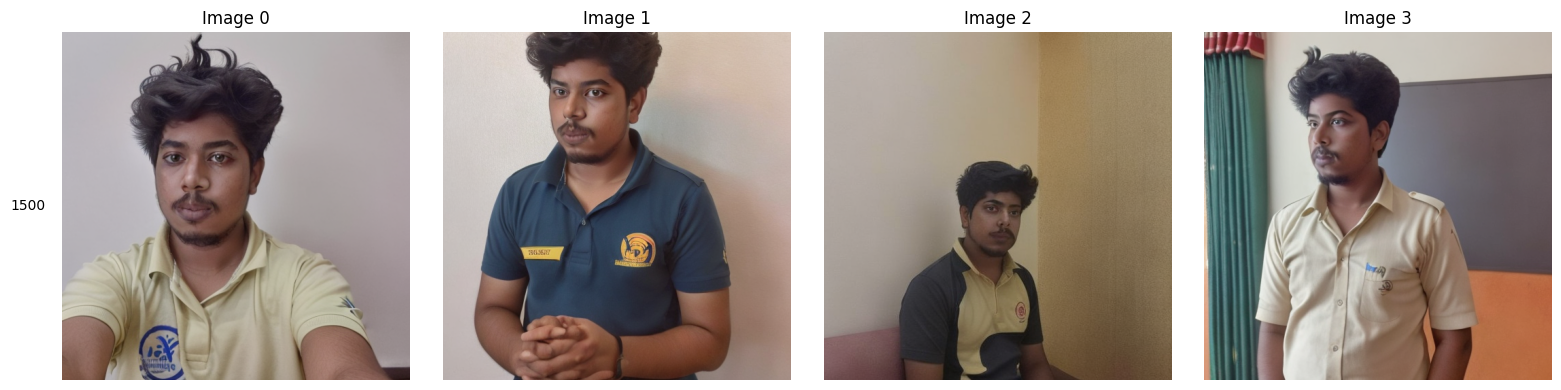

In [11]:
#@markdown Run to generate a grid of preview images from the last saved weights.
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

weights_folder = OUTPUT_DIR
folders = sorted([f for f in os.listdir(weights_folder) if f != "0"], key=lambda x: int(x))

row = len(folders)
col = len(os.listdir(os.path.join(weights_folder, folders[0], "samples")))
scale = 4
fig, axes = plt.subplots(row, col, figsize=(col*scale, row*scale), gridspec_kw={'hspace': 0, 'wspace': 0})

for i, folder in enumerate(folders):
    folder_path = os.path.join(weights_folder, folder)
    image_folder = os.path.join(folder_path, "samples")
    images = [f for f in os.listdir(image_folder)]
    for j, image in enumerate(images):
        if row == 1:
            currAxes = axes[j]
        else:
            currAxes = axes[i, j]
        if i == 0:
            currAxes.set_title(f"Image {j}")
        if j == 0:
            currAxes.text(-0.1, 0.5, folder, rotation=0, va='center', ha='center', transform=currAxes.transAxes)
        image_path = os.path.join(image_folder, image)
        img = mpimg.imread(image_path)
        currAxes.imshow(img, cmap='gray')
        currAxes.axis('off')

plt.tight_layout()
plt.savefig('grid.png', dpi=72)

## Convert weights to ckpt to use in web UIs like AUTOMATIC1111.

In [ ]:
#@markdown Run conversion.
ckpt_path = WEIGHTS_DIR + "/model.ckpt"

half_arg = ""
#@markdown  Whether to convert to fp16, takes half the space (2GB).
fp16 = True #@param {type: "boolean"}
if fp16:
    half_arg = "--half"
!python convert_diffusers_to_original_stable_diffusion.py --model_path $WEIGHTS_DIR  --checkpoint_path $ckpt_path $half_arg
print(f"[*] Converted ckpt saved at {ckpt_path}")

## Inference
### set your model_path parameter according to the above [*] Weights saved at message printed on training logs
### alternatively watch this tutorial to learn : https://youtu.be/kIyqAdd_i10
### e.g. model_path = '/content/stable_diffusion_weights/ohwx/800'

In [12]:
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline, DDIMScheduler
from IPython.display import display

model_path = '/content/stable_diffusion_weights/shrikant5/1500'             # If you want to use previously trained model saved in gdrive, replace this with the full path of model in gdrive

pipe = StableDiffusionPipeline.from_pretrained(model_path, safety_checker=None, torch_dtype=torch.float16).to("cuda")
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.enable_xformers_memory_efficient_attention()
g_cuda = None

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [13]:
#@markdown Can set random seed here for reproducibility.
g_cuda = torch.Generator(device='cuda')
seed = 52362 #@param {type:"number"}
g_cuda.manual_seed(seed)

  0%|          | 0/50 [00:00<?, ?it/s]

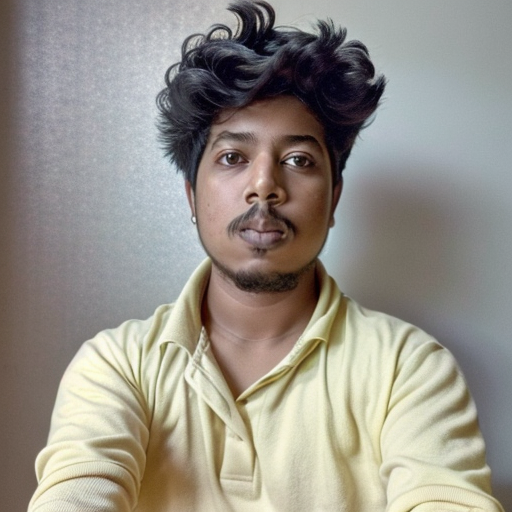

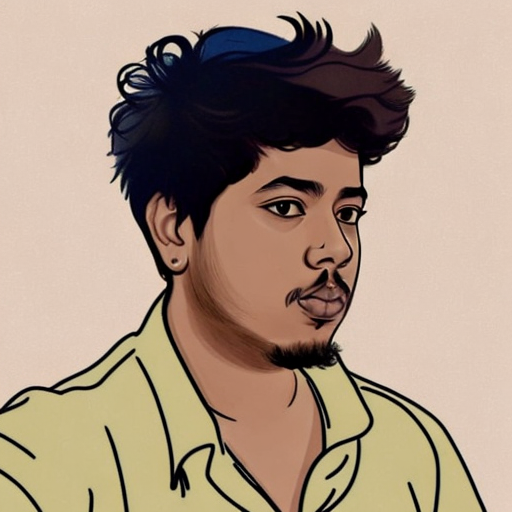

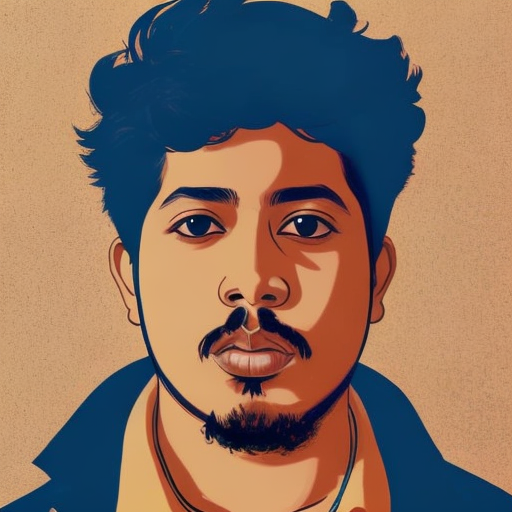

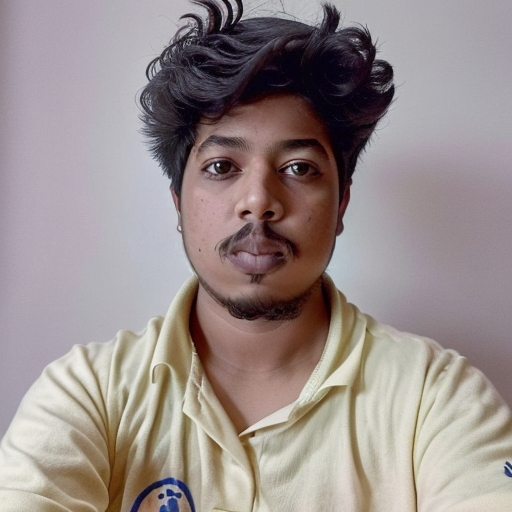

In [15]:
#@title Run for generating images.

prompt = "photo of shrikant5 man in tomer hanuka style" #@param {type:"string"}
negative_prompt = "" #@param {type:"string"}
num_samples = 4 #@param {type:"number"}
guidance_scale = 7.5 #@param {type:"number"}
num_inference_steps = 50 #@param {type:"number"}
height = 512 #@param {type:"number"}
width = 512 #@param {type:"number"}

with autocast("cuda"), torch.inference_mode():
    images = pipe(
        prompt,
        height=height,
        width=width,
        negative_prompt=negative_prompt,
        num_images_per_prompt=num_samples,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=g_cuda
    ).images

for img in images:
    display(img)

In [ ]:
#@markdown Run Gradio UI for generating images.
import gradio as gr

def inference(prompt, negative_prompt, num_samples, height=512, width=512, num_inference_steps=50, guidance_scale=7.5):
    with torch.autocast("cuda"), torch.inference_mode():
        return pipe(
                prompt, height=int(height), width=int(width),
                negative_prompt=negative_prompt,
                num_images_per_prompt=int(num_samples),
                num_inference_steps=int(num_inference_steps), guidance_scale=guidance_scale,
                generator=g_cuda
            ).images

with gr.Blocks() as demo:
    with gr.Row():
        with gr.Column():
            prompt = gr.Textbox(label="Prompt", value="photo of zwx dog in a bucket")
            negative_prompt = gr.Textbox(label="Negative Prompt", value="")
            run = gr.Button(value="Generate")
            with gr.Row():
                num_samples = gr.Number(label="Number of Samples", value=4)
                guidance_scale = gr.Number(label="Guidance Scale", value=7.5)
            with gr.Row():
                height = gr.Number(label="Height", value=512)
                width = gr.Number(label="Width", value=512)
            num_inference_steps = gr.Slider(label="Steps", value=24)
        with gr.Column():
            gallery = gr.Gallery()

    run.click(inference, inputs=[prompt, negative_prompt, num_samples, height, width, num_inference_steps, guidance_scale], outputs=gallery)

demo.launch(debug=True)

In [ ]:
#@title (Optional) Delete diffuser and old weights and only keep the ckpt to free up drive space.

#@markdown [ ! ] Caution, Only execute if you are sure u want to delete the diffuser format weights and only use the ckpt.
import shutil
from glob import glob
import os
for f in glob(OUTPUT_DIR+os.sep+"*"):
    if f != WEIGHTS_DIR:
        shutil.rmtree(f)
        print("Deleted", f)
for f in glob(WEIGHTS_DIR+"/*"):
    if not f.endswith(".ckpt") or not f.endswith(".json"):
        try:
            shutil.rmtree(f)
        except NotADirectoryError:
            continue
        print("Deleted", f)

In [ ]:
#@title Free runtime memory
exit()